# 0. Ready for Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c alzheimers-disease-risk-prediction-eu-business
!unzip alzheimers-disease-risk-prediction-eu-business.zip -d /content/alzheimers/

  0% 0.00/272k [00:00<?, ?B/s]
100% 272k/272k [00:00<00:00, 622MB/s]
Archive:  alzheimers-disease-risk-prediction-eu-business.zip
  inflating: /content/alzheimers/data_description.txt  
  inflating: /content/alzheimers/submission_template.csv  
  inflating: /content/alzheimers/test.csv  
  inflating: /content/alzheimers/train.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(20211001)
tf.random.set_seed(20211001)
pd.set_option('display.max_columns', None)

# 1. Problem & Data

## 1-1. Problem Definition

* The problem is to classify the risk of developing Alzheimer's disease using features related to a person's health and lifestyle<b>("Korean-To-English Translation")</b>.


## 1-2. Data Description

* This pipeline utilizes two datasets, train.csv and test.csv, for predicting the risk of Alzheimer's disease. The data includes various variables such as Patient ID, Age, Gender, Ethnicity, Education Level, BMI, Smoking Status, Alcohol Consumption, Physical Activity, Diet Quality, and Sleep Quality.

* It also contains medical history, such as a family history of Alzheimer's, cardiovascular disease, diabetes, depression, head injury, and hypertension, along with clinical data like blood pressure, cholesterol levels, and MMSE (Mini-Mental State Examination) scores.

* Based on all these variables, the objective is to classify the Diagnosis as 0 (No Alzheimer's) or 1 (Alzheimer's)<b>("Korean-To-English Translation")</b>.

# 2. EDA

In [ ]:
# Load data
train_data = pd.read_csv('/content/alzheimers/train.csv')
test_data = pd.read_csv('/content/alzheimers/test.csv')

In [ ]:
# Basic information
train_data.info()
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719 entries, 0 to 1718
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  1719 non-null   int64  
 1   Age                        1719 non-null   int64  
 2   Gender                     1719 non-null   int64  
 3   Ethnicity                  1719 non-null   int64  
 4   EducationLevel             1719 non-null   int64  
 5   BMI                        1719 non-null   float64
 6   Smoking                    1719 non-null   int64  
 7   AlcoholConsumption         1719 non-null   float64
 8   PhysicalActivity           1719 non-null   float64
 9   DietQuality                1719 non-null   float64
 10  SleepQuality               1719 non-null   float64
 11  FamilyHistoryAlzheimers    1719 non-null   int64  
 12  CardiovascularDisease      1719 non-null   int64  
 13  Diabetes                   1719 non-null   int64

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000
mean,5822.347877,74.960442,0.500291,0.698080,1.283304,27.687408,0.286795,9.978133,4.942195,4.972312,7.038044,0.249564,0.137289,0.155323,0.207679,0.099476,0.152414,134.272833,89.436300,224.902755,124.460516,58.953705,229.276945,14.737994,5.069688,0.205934,0.156486,4.970744,0.201280,0.158813,0.148342,0.161722,0.296684,0.353112
std,620.850386,9.065000,0.500145,0.994836,0.904339,7.209284,0.452396,5.777363,2.827319,2.900920,1.758166,0.432886,0.344252,0.362318,0.405764,0.299388,0.359526,25.885472,17.765068,42.605697,43.343517,23.222822,102.724706,8.639328,2.890435,0.404500,0.363422,2.947606,0.401073,0.365608,0.355542,0.368303,0.456929,0.478076
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,4.002629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,60.000000,150.093316,50.230707,20.003434,50.407194,0.005312,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5292.500000,67.000000,0.000000,0.000000,1.000000,21.641242,0.000000,5.137582,2.612521,2.415726,5.517895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,112.000000,74.000000,189.318298,87.569934,38.534051,137.567872,7.010207,2.562307,0.000000,0.000000,2.324166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5820.000000,75.000000,1.000000,0.000000,1.000000,27.919813,0.000000,9.805564,4.801357,5.050778,7.090395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,134.000000,90.000000,224.563113,123.152236,58.915115,232.702301,14.410221,5.098709,0.000000,0.000000,5.026306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6357.500000,83.000000,1.000000,1.000000,2.000000,33.842594,1.000000,15.181033,7.380416,7.480424,8.552783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,157.000000,105.000000,261.987391,161.901581,78.583338,316.157435,22.228168,7.496824,0.000000,0.000000,7.583825,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.997203,9.999840,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,179.000000,119.000000,299.993352,199.965665,99.959494,399.941862,29.991381,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Check missing values
missing = train_data.isnull().sum()
missing[missing > 0]

,0


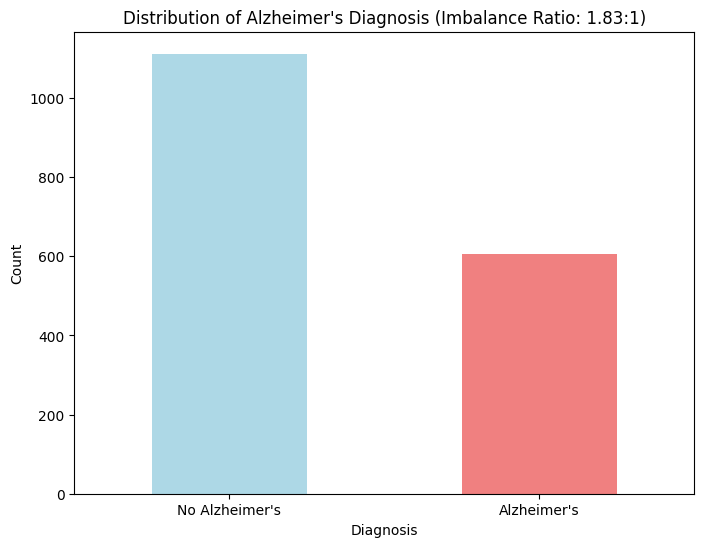

,count
Diagnosis,
0,1112
1,607


In [ ]:
# Target variable distribution
diagnosis_count = train_data['Diagnosis'].value_counts()
ratio = diagnosis_count[0] / diagnosis_count[1]

plt.figure(figsize=(8, 6))
diagnosis_count.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title(f'Distribution of Alzheimer\'s Diagnosis (Imbalance Ratio: {ratio:.2f}:1)')
plt.xticks([0, 1], ['No Alzheimer\'s', 'Alzheimer\'s'], rotation=0)
plt.show()

diagnosis_count

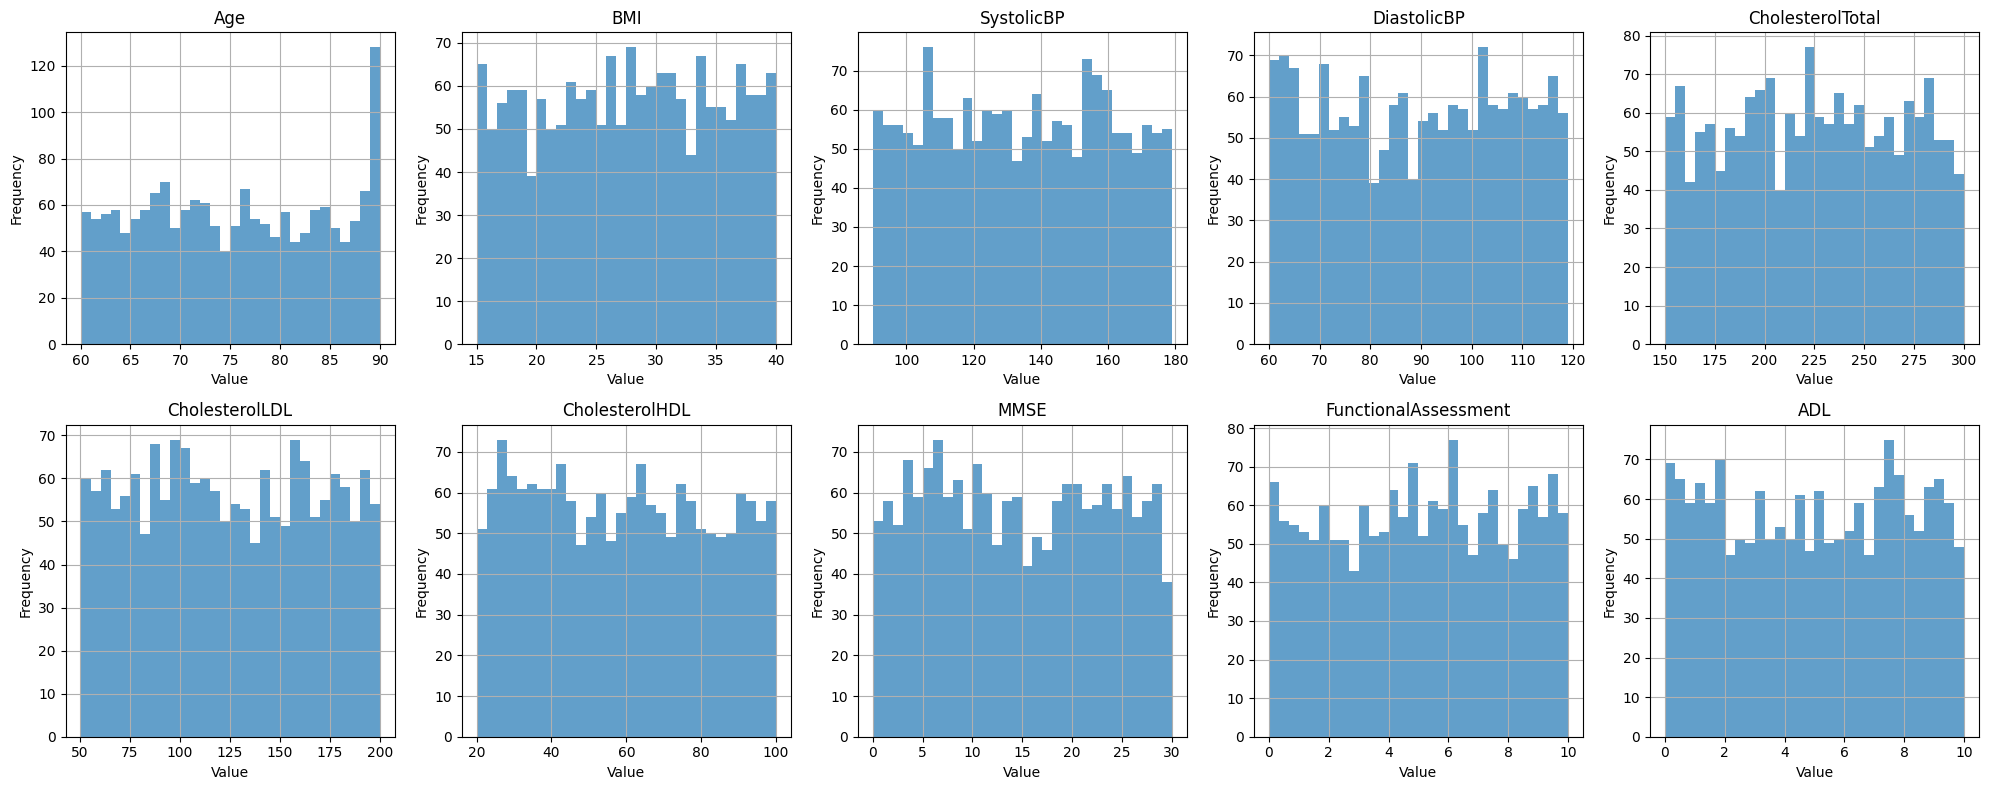

In [ ]:
# Numerical features distribution
num_cols = ['Age', 'BMI', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
            'CholesterolLDL', 'CholesterolHDL', 'MMSE', 'FunctionalAssessment', 'ADL']

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
ax = ax.ravel()

for i, col in enumerate(num_cols):
    train_data[col].hist(bins=30, ax=ax[i], alpha=0.7)
    ax[i].set_title(col)
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

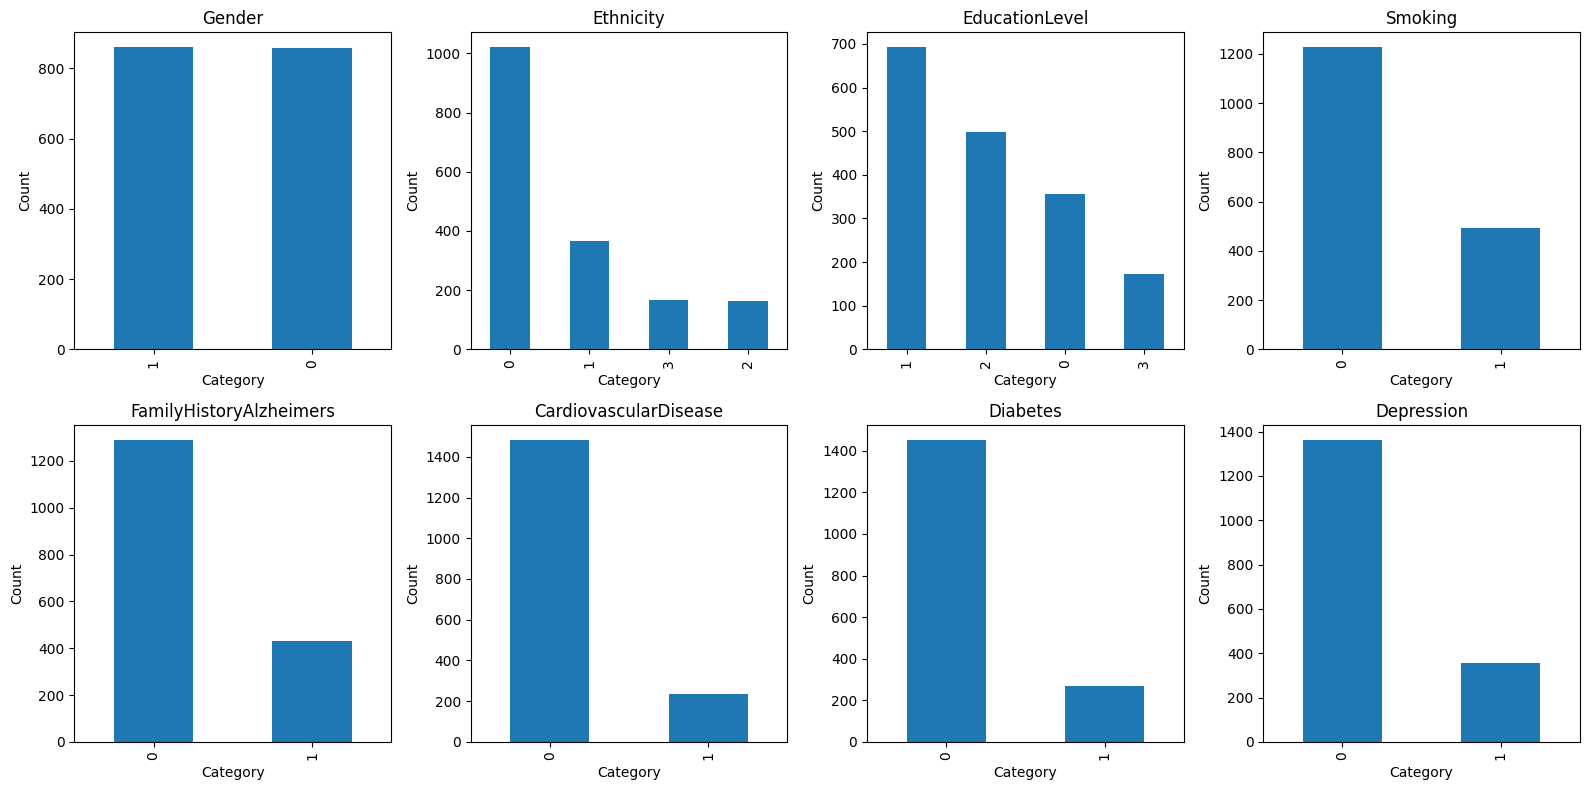

In [ ]:
# Categorical features distribution
cat_cols = ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking',
            'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression']

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.ravel()

for i, col in enumerate(cat_cols):
    train_data[col].value_counts().plot(kind='bar', ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel('Category')
    ax[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

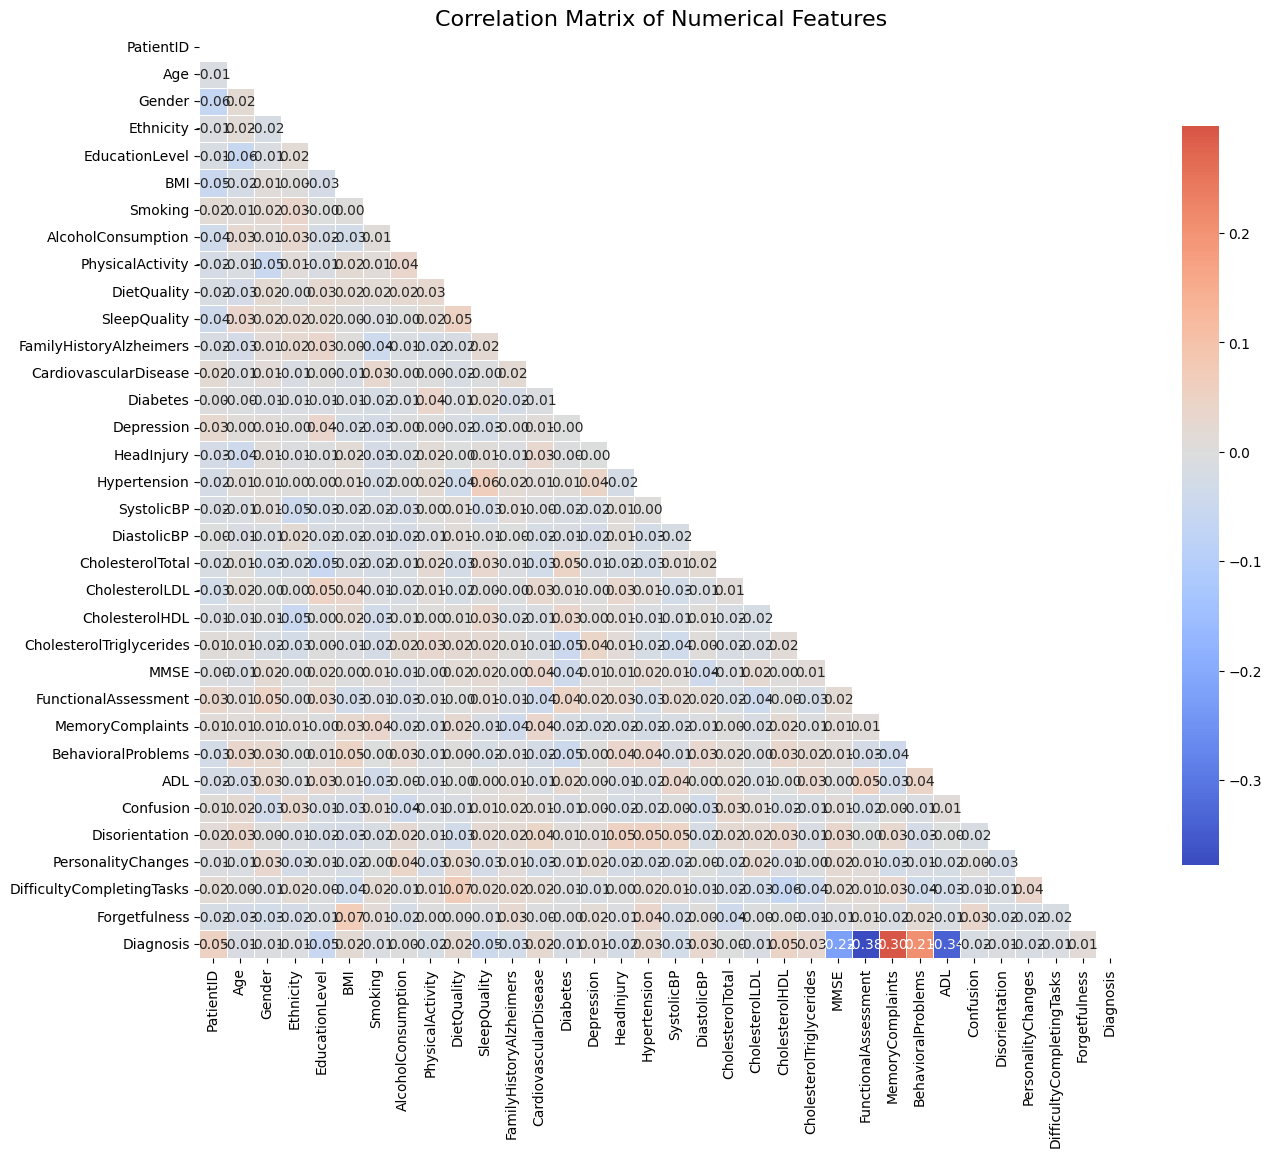

In [ ]:
# Correlation matrix
plt.figure(figsize=(15, 12))
corr_matrix = train_data.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

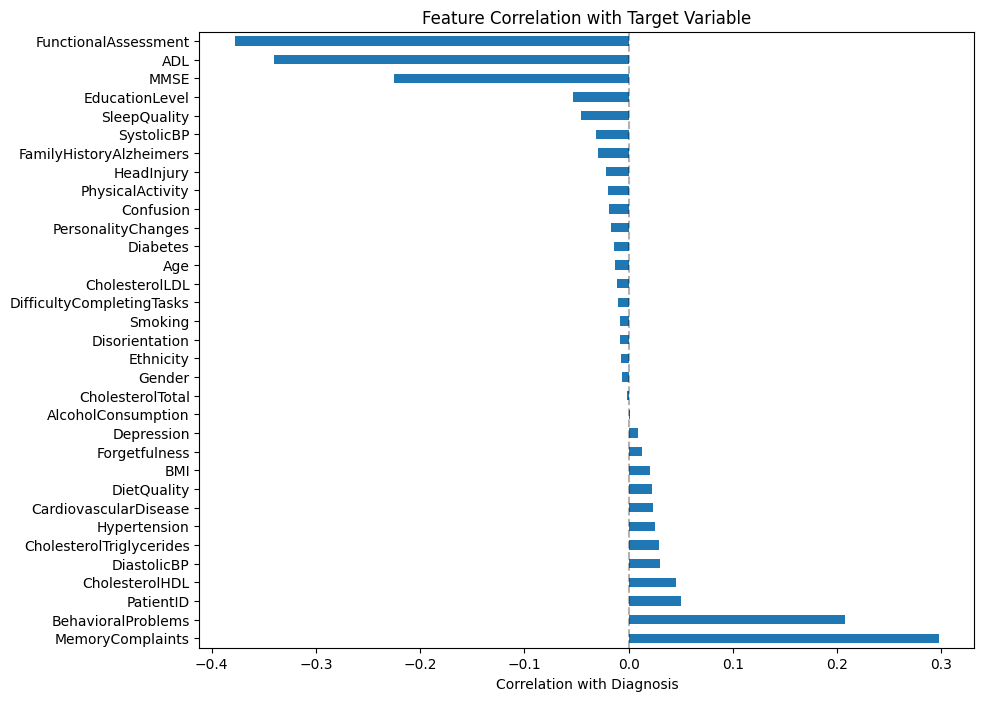

In [ ]:
# Features correlation with target
numeric_data = train_data.select_dtypes(include=[np.number])
corr_with_target = numeric_data.corr()['Diagnosis'].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
corr_with_target[1:].plot(kind='barh')
plt.xlabel('Correlation with Diagnosis')
plt.title('Feature Correlation with Target Variable')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.show()

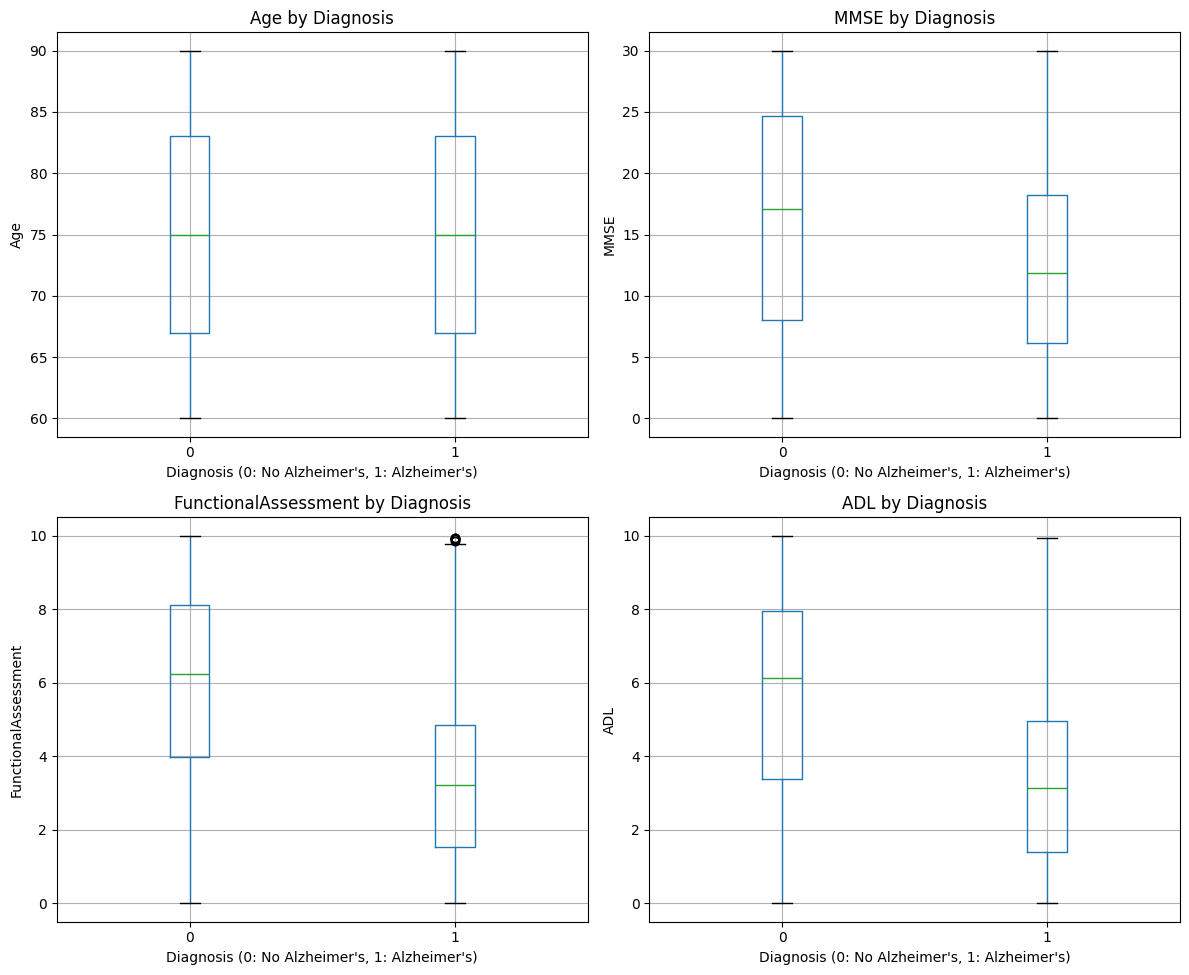

In [ ]:
# Box plots for key numerical features by diagnosis
important_features = ['Age', 'MMSE', 'FunctionalAssessment', 'ADL']

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.ravel()

for i, col in enumerate(important_features):
    train_data.boxplot(column=col, by='Diagnosis', ax=ax[i])
    ax[i].set_title(f'{col} by Diagnosis')
    ax[i].set_xlabel('Diagnosis (0: No Alzheimer\'s, 1: Alzheimer\'s)')
    ax[i].set_ylabel(col)

plt.suptitle('')
plt.tight_layout()
plt.show()

# 3. Architecture

## 3-1. Data Preprocessing

* The following preprocessing steps were performed:

 * The PatientID and DoctorInCharge columns were removed as they are not directly relevant to model training.

 * The training data was separated into independent variables (X) and a dependent variable (y).

 * The numerical features were normalized.

 * There was a significant data imbalance in the Diagnosis target, with many more non-Alzheimer's cases (0) than Alzheimer's cases (1). To handle this, Focal Loss was used as the loss function.

 * The training dataset was further split into new training and validation sets at an 80:20 ratio<b>("Korean-To-English Translation")</b>.

In [ ]:
# Remove unnecessary columns
X = train_data.drop(['PatientID', 'Diagnosis', 'DoctorInCharge'], axis=1)
y = train_data['Diagnosis']

# One-hot encode Ethnicity
X_with_dummies = pd.get_dummies(X, columns=['Ethnicity'], prefix='Ethnicity')

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    X_with_dummies, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Convert to float32 for TensorFlow
x_train_scaled = x_train_scaled.astype(np.float32)
x_test_scaled = x_test_scaled.astype(np.float32)
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

# Check shapes
x_train_scaled.shape, x_test_scaled.shape

((1375, 35), (344, 35))

## 3-2. Model Architecture


* Structure of Model

 * The model consists of 3 hidden layers, with each layer comprising BatchNorm, LeakyReLU, and Dropout.
   * He initialization and the LeakyReLU activation function were used to mitigate the gradient vanishing problem.

   * BatchNorm and Dropout were included to prevent overfitting.

 * The AdamW optimizer was used.

 * Focal Loss was employed as the loss function<b>("Korean-To-English Translation")</b>.

In [ ]:
# Focal Loss implementation
def my_loss(alpha=0.25, gamma=2.0):
    def loss_function(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Calculate focal loss
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        focal_weight = alpha_factor * tf.pow((1 - p_t), gamma)

        # Binary crossentropy
        bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        focal_loss = focal_weight * bce

        return tf.reduce_mean(focal_loss)

    return loss_function

In [ ]:
net = keras.Sequential([
    # Input layer
    layers.Input(shape=(x_train_scaled.shape[1],)),

    # hidden layer 1
    layers.Dense(64, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.25),

    # hidden layer 2
    layers.Dense(32, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.3),

    # hidden layer 3
    layers.Dense(16, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(1, activation='sigmoid')
])

net.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 64)             │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,153 (20.13 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# AdamW
net.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.05),
    loss=my_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

In [ ]:
#callbacks
stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

my_callbacks = [stop_early, lr_reduce]

In [ ]:
# Train
train_history = net.fit(
    x_train_scaled, y_train,
    validation_data=(x_test_scaled, y_test),
    epochs=200,
    batch_size=32,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.4991 - auc: 0.5113 - loss: 0.2310 - precision: 0.3510 - recall: 0.5137 - val_accuracy: 0.5610 - val_auc: 0.6297 - val_loss: 0.1573 - val_precision: 0.4219 - val_recall: 0.6694 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5620 - auc: 0.5500 - loss: 0.1786 - precision: 0.3899 - recall: 0.4509 - val_accuracy: 0.6541 - val_auc: 0.7068 - val_loss: 0.0897 - val_precision: 0.5078 - val_recall: 0.5372 - learning_rate: 0.0010
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6134 - auc: 0.5938 - loss: 0.1324 - precision: 0.4393 - recall: 0.4149 - val_accuracy: 0.7093 - val_auc: 0.7517 - val_loss: 0.0677 - val_precision: 0.6329 - val_recall: 0.4132 - learning_rate: 0.0010
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6276 - auc: 0.6045 - loss: 0.1066 - precision: 0.4564 - recall: 0.3503 - val_accuracy: 0.7267 - val_auc: 0.7779 - val_loss: 0.0595 - val_

# 4. Results

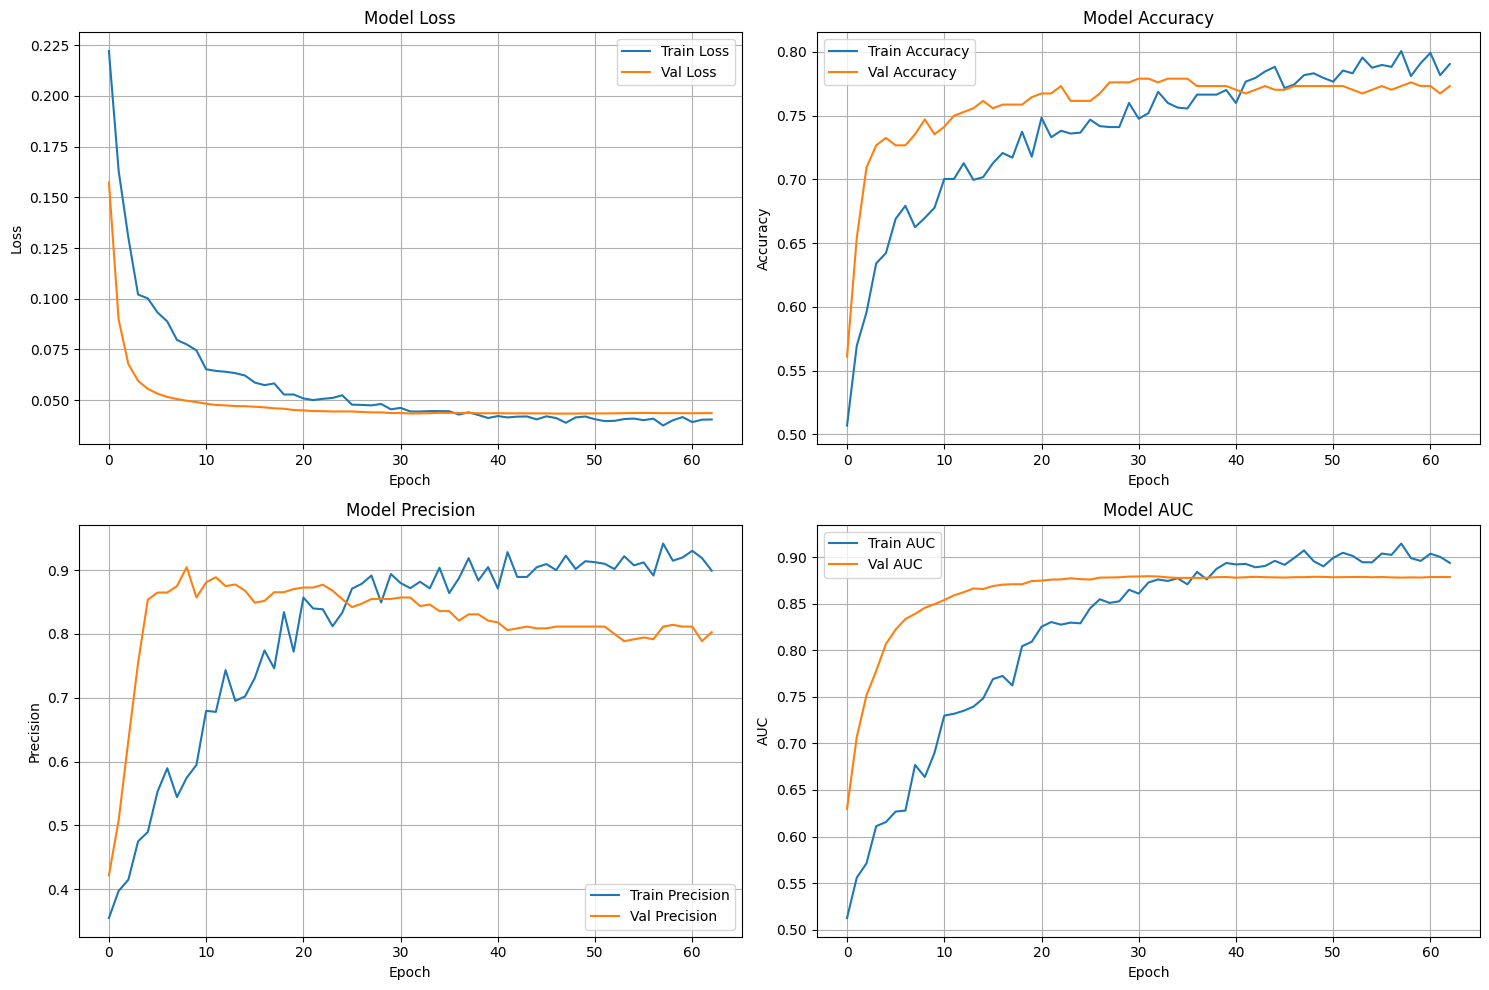

In [ ]:
# Plot training history
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Loss
ax[0, 0].plot(train_history.history['loss'], label='Train Loss')
ax[0, 0].plot(train_history.history['val_loss'], label='Val Loss')
ax[0, 0].set_title('Model Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0, 0].grid(True)

# Accuracy
ax[0, 1].plot(train_history.history['accuracy'], label='Train Accuracy')
ax[0, 1].plot(train_history.history['val_accuracy'], label='Val Accuracy')
ax[0, 1].set_title('Model Accuracy')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Accuracy')
ax[0, 1].legend()
ax[0, 1].grid(True)

# Precision
ax[1, 0].plot(train_history.history['precision'], label='Train Precision')
ax[1, 0].plot(train_history.history['val_precision'], label='Val Precision')
ax[1, 0].set_title('Model Precision')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Precision')
ax[1, 0].legend()
ax[1, 0].grid(True)

# AUC
ax[1, 1].plot(train_history.history['auc'], label='Train AUC')
ax[1, 1].plot(train_history.history['val_auc'], label='Val AUC')
ax[1, 1].set_title('Model AUC')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('AUC')
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate model
test_loss, test_acc, test_prec, test_rec, test_auc = net.evaluate(x_test_scaled, y_test, verbose=0)

# Display metrics in DataFrame
results = pd.DataFrame({
    'Metric': ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC'],
    'Value': [test_loss, test_acc, test_prec, test_rec, test_auc]
})
results['Value'] = results['Value'].round(4)
results

,Metric,Value
0,Loss,0.0433
1,Accuracy,0.7733
2,Precision,0.8116
3,Recall,0.4628
4,AUC,0.8785


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


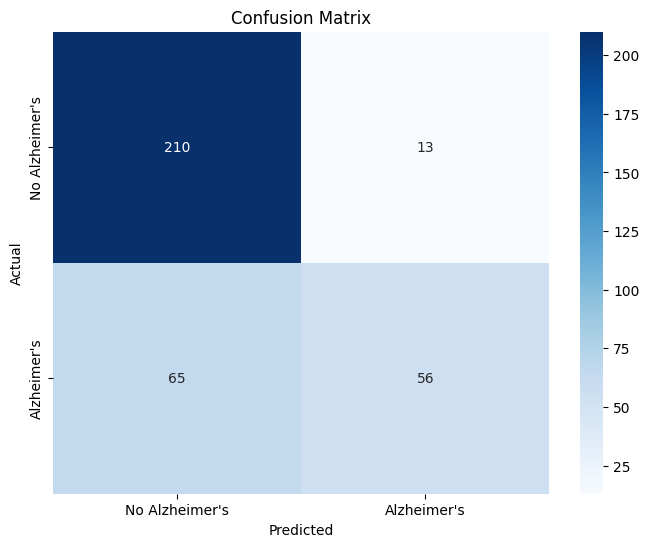

,precision,recall,f1-score,support
No Alzheimer's,0.763636,0.941704,0.843373,223.000000
Alzheimer's,0.811594,0.462810,0.589474,121.000000
accuracy,0.773256,0.773256,0.773256,0.773256
macro avg,0.787615,0.702257,0.716424,344.000000
weighted avg,0.780505,0.773256,0.754066,344.000000


In [ ]:
# Make predictions
pred_proba = net.predict(x_test_scaled)
pred_class = (pred_proba > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_test, pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Alzheimer\'s', 'Alzheimer\'s'],
            yticklabels=['No Alzheimer\'s', 'Alzheimer\'s'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, pred_class, target_names=['No Alzheimer\'s', 'Alzheimer\'s'], output_dict=True)
pd.DataFrame(report).transpose()

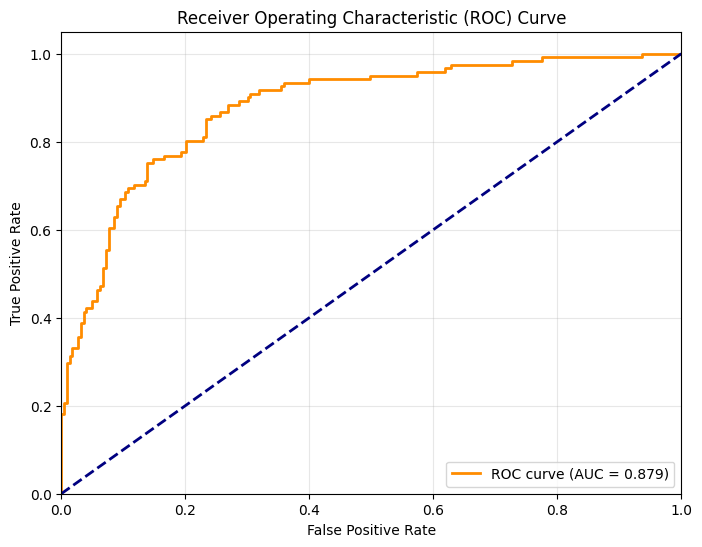

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_proba)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

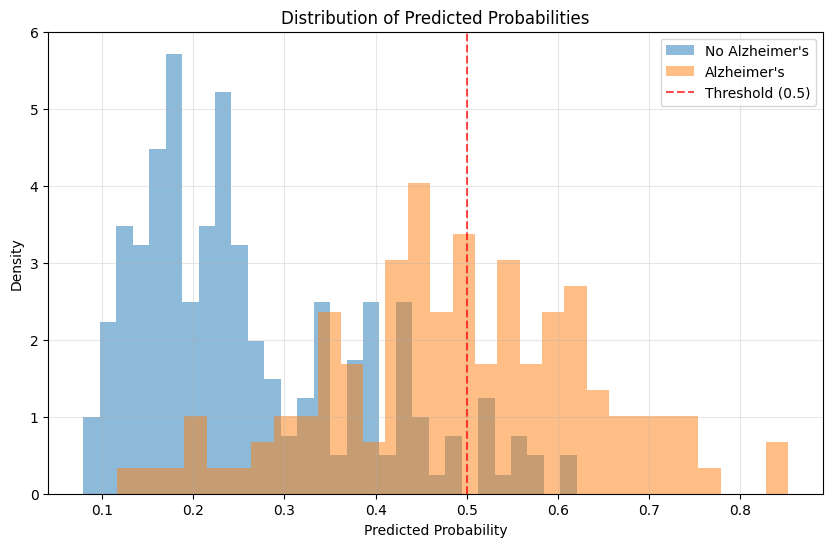

In [ ]:
# Prediction probability distribution
plt.figure(figsize=(10, 6))
plt.hist(pred_proba[y_test == 0], bins=30, alpha=0.5, label='No Alzheimer\'s', density=True)
plt.hist(pred_proba[y_test == 1], bins=30, alpha=0.5, label='Alzheimer\'s', density=True)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold (0.5)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Conclusion

* Results & Interpretation

 * The model achieved an accuracy of 81.10% and an AUC score of 0.88 on the validation dataset.

 * Precision was approximately 83.54%, and Recall was approximately 89.53%.

 * F1 score was approximately 86.42%.

 * It is concluded that using Focal Loss and the AdamW Optimizer enabled relatively stable training even with imbalanced data<b>("Korean-To-English Translation")</b>.


* Shortcomings

 * The most significant shortcoming is the low recall for the Alzheimer's class. In a medical diagnostic scenario, failing to identify a patient at risk (a false negative) can have much more severe consequences than a false positive. The current model would miss more than half of the at-risk patients, limiting its real-world clinical utility.

 * The dataset used may be biased towards specific populations or regions and may not fully reflect the complexity of a real-world clinical environment.

 * As a Deep Neural Network (DNN), the model is a "black box," making it difficult to explain which features had a decisive impact on its predictions<b>("Korean-To-English Translation")</b>.

* Future improvements

 * Adopting xAI (Explainable AI) techniques such as SHAP (Shapley Additive Explanations) or LIME (Local Interpretable Model-agnostic Explanations) could enhance the model's transparency and interpretability.

 * Ensembling with other models like XGBoost or LightGBM is expected to improve the model's performance.

 * The optimal combination of settings can be found through hyperparameter optimization for values like the learning rate, dropout ratio, and the alpha/gamma parameters of Focal Loss<b>("Korean-To-English Translation")</b>.

# 6. Submission

In [ ]:
# Prepare test data
test_features = test_data.drop(['PatientID', 'DoctorInCharge'], axis=1)

# Apply same preprocessing as training data
test_with_dummies = pd.get_dummies(test_features, columns=['Ethnicity'], prefix='Ethnicity')

# Ensure test data has same columns as training data
missing_cols = set(X_with_dummies.columns) - set(test_with_dummies.columns)
for col in missing_cols:
    test_with_dummies[col] = 0
test_with_dummies = test_with_dummies[X_with_dummies.columns]

# Scale test data
test_scaled = scaler.transform(test_with_dummies)
test_scaled = test_scaled.astype(np.float32)

In [ ]:
# Make predictions on test set
final_predictions = net.predict(test_scaled)

# Create submission dataframe with probabilities
submission = pd.DataFrame({
    'PatientID': test_data['PatientID'],
    'Diagnosis': final_predictions.flatten()
})

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
# Verify submission format
sub_info = pd.DataFrame({
    'Info': ['Shape', 'Min Diagnosis', 'Max Diagnosis', 'Mean Diagnosis'],
    'Value': [str(submission.shape),
              f"{submission['Diagnosis'].min():.4f}",
              f"{submission['Diagnosis'].max():.4f}",
              f"{submission['Diagnosis'].mean():.4f}"]
})
display(sub_info)
submission.head()

,Info,Value
0,Shape,"(430, 2)"
1,Min Diagnosis,0.0666
2,Max Diagnosis,0.8719
3,Mean Diagnosis,0.3273


,PatientID,Diagnosis
0,5910,0.128828
1,6573,0.243332
2,5729,0.261162
3,5510,0.163489
4,5625,0.114257


In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7. References

* Kaggle Competition: Alzheimer's Disease Risk Prediction EU Business. Retrieved from https://www.kaggle.com/competitions/alzheimers-disease-risk-prediction-eu-business/

* "Korean-To-English Translation" prompt. Gemini, Google, 29 July 2025, https://g.co/gemini/share/a30e9f6addf9

# 8. Github

- https://github.com/mulkib/csca5642.git